In [1]:
%pylab inline
import galsim

Populating the interactive namespace from numpy and matplotlib


In [2]:
gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.2           #
pixel_scale = 0.2  # arcsec / pixel


psf_beta = 5       #
psf_re = 1.0       # arcsec


# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=256,ny=256, scale=pixel_scale),
                               x_interpolant='linear')

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal0 = gal.shear(g1=g1, g2=g2)

psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_re)

gal = galsim.Convolve([gal0, psf])

In [3]:
image_original = gal0.original.drawImage(nx=256,ny=256, scale=pixel_scale, method='no_pixel').array
image_shear = gal.drawImage(nx=256,ny=256,scale=pixel_scale, method='no_pixel').array

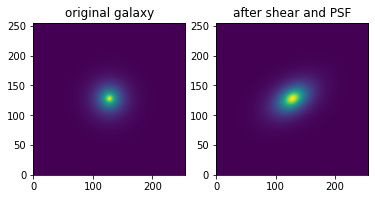

In [4]:
subplot(121)
imshow(image_original, origin='lower')
title('original galaxy')
subplot(122)
title('after shear and PSF')
imshow(image_shear, origin='lower')

In [5]:
import tensorflow as tf
# let's try to do shape measurement using weigthed moments
nx = 256
ny = 256
XX=np.zeros((nx,ny))
XY=np.zeros((nx,ny))
YY=np.zeros((nx,ny))
w = np.zeros((nx,ny))
sigma=40

for i in range(0,nx):
    x=0.5+i-(nx)/2.0
    for j in range(0,ny):
        y=0.5+j-(ny)/2.0
        XX[i,j]=x*x
        XY[i,j]=x*y
        YY[i,j]=y*y
        w[i,j]=np.exp(-((x) ** 2 + (y) ** 2) /
                               (2 * sigma ** 2))

def get_ellipticity(img):
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    norm = tf.reduce_sum(w*img)
    Q11 = tf.reduce_sum(w*img*YY)/norm
    Q12 = tf.reduce_sum(w*img*XY)/norm
    Q21 = Q12
    Q22 = tf.reduce_sum(w*img*XX)/norm
    
    q1 = Q11 - Q22
    q2 = 2*Q12
    
    T= Q11 + Q22  + 2*tf.sqrt(Q11*Q22 - Q12**2)
    return q1/T, q2/T

In [6]:
get_ellipticity(image_shear+10*randn(256,256))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.06894009>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1391387>)

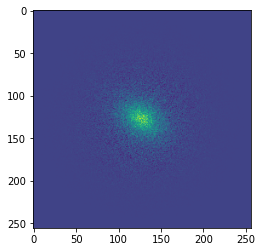

In [7]:
imshow(w*(image_shear+10*randn(256,256)))

In [8]:
# We draw the PSF image in Kspace at the correct resolution
N = 256
im_scale = pixel_scale
interp_factor=2
padding_factor=2
Nk = N*interp_factor*padding_factor
from galsim.bounds import _BoundsI
bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)

impsf = psf.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)
impsf = fftshift(impsf.array.reshape(1,Nk,Nk//2+1), axes=1)
impsf = tf.convert_to_tensor(impsf, dtype=tf.complex64)

invpsf = galsim.Deconvolve(psf)

invimpsf = invpsf.drawKImage(bounds=bounds,
                       scale=2.*np.pi/(N*padding_factor* im_scale),
                       recenter=False)
invimpsf = fftshift(invimpsf.array.reshape(1,Nk,Nk//2+1), axes=1)
invimpsf = tf.convert_to_tensor(invimpsf, dtype=tf.complex64)

In [9]:
# We draw the galaxy on a postage stamp
imgal = gal.drawImage(nx=256, ny=256, scale=pixel_scale,
                      method='no_pixel',use_true_center=False)
imgal = imgal.array.reshape(1,N,N,1)
imgal = tf.convert_to_tensor(imgal, dtype=tf.float32)

In [10]:
import galflow as gf

In [21]:
# Deconvolve image
imin = imgal+0*randn(1,256,256,1)
tst = gf.convolve(imin, invimpsf)
# Reconvolve image
tst2 = gf.convolve(tst, impsf)

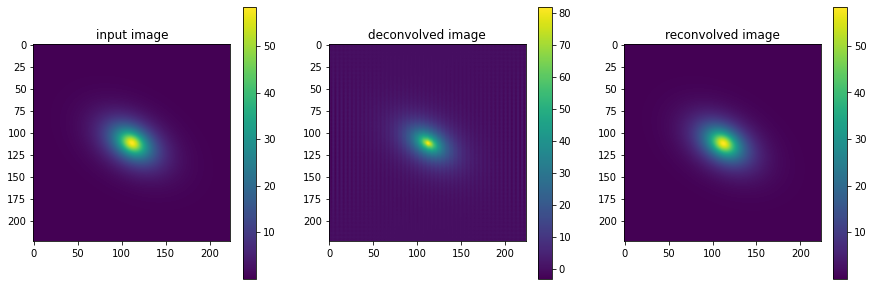

In [22]:
figure(figsize=[15,5])
subplot(131)
title('input image')
imshow(imin[0,16:-16,16:-16,0]);colorbar();
subplot(132)
title('deconvolved image')
imshow(tst[0,16:-16,16:-16,0]);colorbar();
subplot(133)
title('reconvolved image')
imshow(tst2[0,16:-16,16:-16,0]); colorbar();

In [23]:
# Ok... so now can we make a poor man's metacal

def metacal_shear(gal_img, inv_psf_img, psf_img, g1, g2):
    g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
    g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])
        
    # Step1: remove observed psf
    img = gf.convolve(gal_img, inv_psf_img)
    
    # Step2: add shear layer
    img = gf.shear(img, g1, g2)
    
    # Step3: apply PSF again
    img = gf.convolve(img, psf_img)
    
    # Step4: compute ellipticity
    return tf.stack(get_ellipticity(img[0,:,:,0]))

In [24]:
res = metacal_shear(imin, invimpsf, impsf, 0.0, 0.0)

In [42]:
res.numpy()

array([0.06822549, 0.13610113], dtype=float32)

In [31]:
# True ellipticity: [0.1, 0.2]
g = tf.zeros(2)
with tf.GradientTape() as tape:
    tape.watch(g)
    # Measure ellipticity under metacal
    e = metacal_shear(imin, invimpsf, impsf, g[0], g[1])
# Compute response matrix
R = tape.jacobian(e, g)

In [35]:
# Apply inverse response matrix :-D
calibrated_e = tf.linalg.inv(R) @ tf.reshape(e,[2,1])

In [41]:
print("measured ellipticity  ", e.numpy())
print("calibrated ellipticity", calibrated_e.numpy().squeeze())
print("true g1,g2            ",np.array([g1,g2]))

measured ellipticity   [0.06822549 0.13610113]
calibrated ellipticity [0.10956747 0.2119946 ]
true g1,g2             [0.1 0.2]
